In [1]:
"""
Author: Jose P. Teran
Date: 2026-01-19

Description:
Evaluate outputs of reservoir storage for ISIMIP 3A models against reference data

Summary analysis

"""

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import argparse
import matplotlib.pyplot as plt
import hydroeval as he
import seaborn as sns
from matplotlib.collections import PolyCollection
from matplotlib.patches import Rectangle
import textwrap
from matplotlib.patches import Patch
from matplotlib.ticker import AutoMinorLocator

os.chdir('/media/jopato/jopato_ssd/PHD/PHD_main/Projects/CoSWAT/Paper_Ch2/codeAndDataAvailability/teran_et_al_2026_coswat_reservoirs')#'/data/brussel/vo/000/bvo00033') # All relative paths will be based on this ! !
analysis_folder = 'Scripts/result_analysis' #f'vsc10883/PHD_main/Projects/CoSWAT/Scripts/result_analysis'

In [2]:
# Paths and file names
# ====================

stats_dir = f'{analysis_folder}/reservoirs_coswat/validation/isimipModels/stats'

regions = os.listdir(stats_dir)

data_list = []
for region in regions:
    df = pd.read_csv(f'{stats_dir}/{region}/storage_stats_by_reservoir.csv')
    data_list.append(df)

data_df = pd.concat(data_list).reset_index(drop=True)

In [3]:
# Long dataframes for plotting
kge_cols   = [c for c in data_df.columns if c.startswith("kge_")]
pbias_cols = [c for c in data_df.columns if c.startswith("pbias_")]
r_cols     = [c for c in data_df.columns if c.startswith("r_")]

kge_long = data_df.melt("grand_id", kge_cols,   var_name="model", value_name="kge")
pb_long  = data_df.melt("grand_id", pbias_cols, var_name="model", value_name="pbias")
r_long   = data_df.melt("grand_id", r_cols,     var_name="model", value_name="r")

kge_long["model"] = kge_long["model"].str.replace("^kge_", "", regex=True)
pb_long["model"]  = pb_long["model"].str.replace("^pbias_", "", regex=True)
r_long["model"]   = r_long["model"].str.replace("^r_", "", regex=True)


In [4]:
def remove_outliers(g, col): 
    q1 = g[col].quantile(0.25) 
    q3 = g[col].quantile(0.75) 
    iqr = q3 - q1 
    low = q1 - 1.5 * iqr 
    high = q3 + 1.5 * iqr 
    return g[(g[col] >= low) & (g[col] <= high)]

kge_long_clean = kge_long.copy().groupby("model", group_keys=False).apply(lambda g: remove_outliers(g, "kge")).reset_index(drop=True)
pb_long_clean = pb_long.copy().groupby("model", group_keys=False).apply(lambda g: remove_outliers(g, "pbias")).reset_index(drop=True)
r_long_clean = r_long.copy().groupby("model", group_keys=False).apply(lambda g: remove_outliers(g, "r")).reset_index(drop=True)

/tmp/ipykernel_42062/2690300975.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  kge_long_clean = kge_long.copy().groupby("model", group_keys=False).apply(lambda g: remove_outliers(g, "kge")).reset_index(drop=True)
/tmp/ipykernel_42062/2690300975.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pb_long_clean = pb_long.copy().groupby("model", group_keys=False).apply(lambda g: remove_outliers(g, "pbias")).reset_

In [5]:
isimipColorDict = {
    "h08": "thistle",
    "cwatm": "slateblue",
    "lpjml5-7-10-fire": "silver",
    "miroc-integ-land": "wheat",
    "watergap2-2e": "cadetblue",
}
coswat_color = "black"

/tmp/ipykernel_42062/1903501657.py:203: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped, fontsize=8)


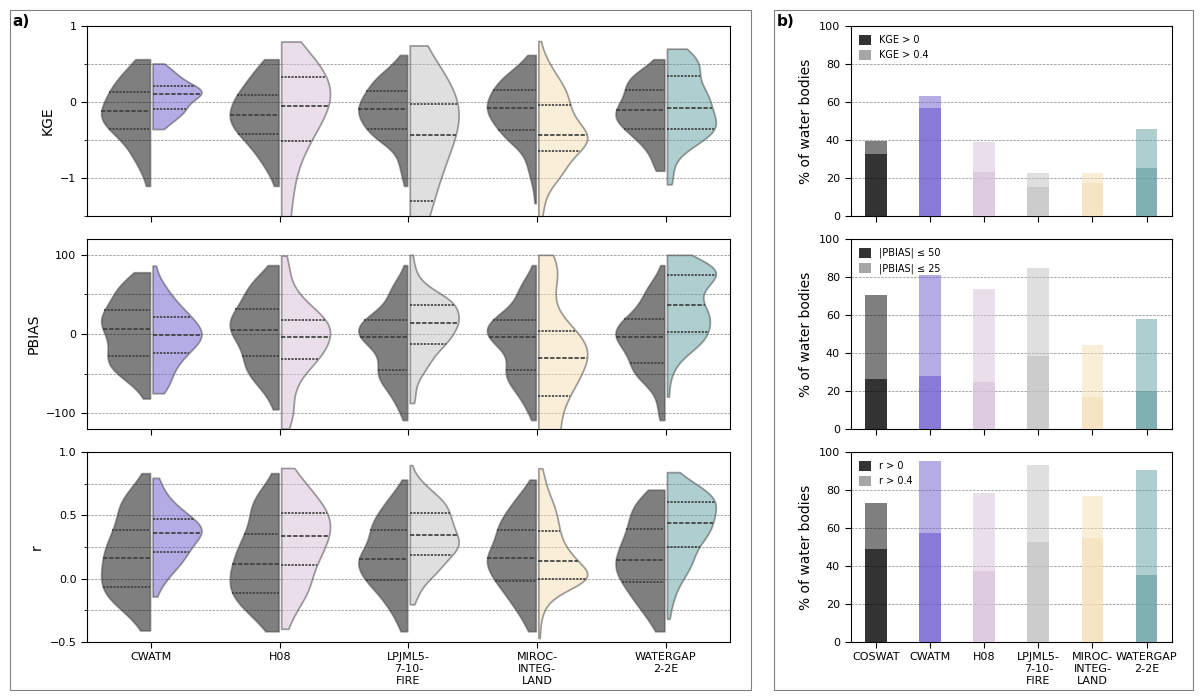

In [7]:
# def violin_plot(ax, df_long, ycol, ylim=None):
#     models = sorted(df_long["model"].dropna().unique())
#     models.remove('CoSWAT')
#     rows = []

#     for model in models:
#         df_coswat = df_long[df_long['model'].str.lower()=="coswat"][[ycol]].copy()
#         df_coswat["group"] = model.upper()
#         df_coswat["side"]  = "CoSWAT"
        

        
#         df_m = df_long[df_long["model"] == model][[ycol]].copy()
#         df_m["group"] = model.upper()
#         df_m["side"]  = model.upper()

#         rows.append(df_coswat)
#         rows.append(df_m)    

#     plot_df = pd.concat(rows, ignore_index=True)
#     plot_df["side"] = plot_df["side"].apply(lambda x: "CoSWAT" if x == "CoSWAT" else "model")
#     plot_df["side"] = pd.Categorical(plot_df["side"],categories=["CoSWAT", "model"],ordered=True)
    
#     order = [m.upper() for m in models]
    
#     sns.violinplot(data=plot_df,x="group",y=ycol,hue='side',hue_order=["CoSWAT", "model"],order=order,split='True',inner='quart',gap=0.05,legend=False,cut=0,density_norm='width',ax=ax)
    
#     if ylim is not None:
#         ax.set_ylim(*ylim)
    
#     ax.grid(False)
#     bodies = [c for c in ax.collections if isinstance(c, PolyCollection)]

#     for i, m in enumerate(models):
#         cos_body   = bodies[2*i]      # CoSWAT half
#         model_body = bodies[2*i + 1]  # model half

#         cos_body.set_facecolor(coswat_color)
#         cos_body.set_alpha(0.5)

#         model_body.set_facecolor(isimipColorDict.get(m.lower(), "lightgray"))
#         model_body.set_alpha(0.5)
    
#     for spine in ax.spines.values():
#         spine.set_edgecolor("black")
#         # spine.set_linewidth(1.0)
        
#     ax.tick_params(axis="both", which="major", bottom=True, left=True, length=4, width=0.8, direction="out")

def violin_plot(ax, df_long, ycol, ylim=None):
    models = sorted(df_long["model"].dropna().unique())
    models.remove('CoSWAT')
    rows = []

    for model in models:
        df_coswat = df_long[df_long['model'].str.lower()=="coswat"][["grand_id",ycol]].copy()
        df_m      = df_long[df_long["model"]==model][["grand_id",ycol]].copy()

        df_coswat = df_coswat.dropna(subset=[ycol])
        df_m      = df_m.dropna(subset=[ycol])

        common_ids = set(df_coswat["grand_id"]).intersection(df_m["grand_id"])
        df_coswat  = df_coswat[df_coswat["grand_id"].isin(common_ids)]
        df_m       = df_m[df_m["grand_id"].isin(common_ids)]

        df_coswat["group"] = model.upper()
        df_coswat["side"]  = "CoSWAT"

        df_m["group"] = model.upper()
        df_m["side"]  = model.upper()

        rows.append(df_coswat)
        rows.append(df_m)

    plot_df = pd.concat(rows, ignore_index=True)
    plot_df["side"] = plot_df["side"].apply(lambda x: "CoSWAT" if x=="CoSWAT" else "model")
    plot_df["side"] = pd.Categorical(plot_df["side"],categories=["CoSWAT","model"],ordered=True)

    order = [m.upper() for m in models]

    sns.violinplot(data=plot_df,x="group",y=ycol,hue="side",hue_order=["CoSWAT","model"],order=order,split=True,inner="quart",gap=0.05,legend=False,cut=0,density_norm="width",ax=ax)

    if ylim is not None:
        ax.set_ylim(*ylim)

    ax.grid(False)
    bodies = [c for c in ax.collections if isinstance(c, PolyCollection)]

    for i,m in enumerate(models):
        cos_body   = bodies[2*i]
        model_body = bodies[2*i+1]

        cos_body.set_facecolor(coswat_color)
        cos_body.set_alpha(0.5)

        model_body.set_facecolor(isimipColorDict.get(m.lower(),"lightgray"))
        model_body.set_alpha(0.5)

    for spine in ax.spines.values():
        spine.set_edgecolor("black")

    ax.tick_params(axis="both",which="major",bottom=True,left=True,length=4,width=0.8,direction="out")

def threshold_stats(df, model_col, val_col, t1, t2=None, mode="gt"):
    rows = []
    for m, g in df.groupby(model_col):
        n = len(g)
        if n == 0:
            continue

        if mode == "gt":
            p1 = (g[val_col] > t1).sum() / n * 100
            p2 = (g[val_col] > t2).sum() / n * 100 if t2 is not None else 0

        elif mode == "abs":
            p1 = (g[val_col].abs() <= t1).sum() / n * 100
            p2 = (g[val_col].abs() <= t2).sum() / n * 100 if t2 is not None else 0

        rows.append([m, p1, p2])

    return pd.DataFrame(rows, columns=["model", "outer", "inner"])


def stacked_bar(ax, stats_df, lab_outer, lab_inner):
    stats_df = stats_df.sort_values("model")
    x = np.arange(len(stats_df))

    outer = stats_df["outer"].values
    inner = stats_df["inner"].values
    diff  = outer - inner

    for i, (m, o, d, inn) in enumerate(zip(stats_df["model"], outer, diff, inner)):
        color = coswat_color if m.lower() == "coswat" else isimipColorDict.get(m.lower(), "lightgray")
        bar_width = 0.4
        ax.bar(i, d, width=bar_width, color=color, alpha=0.8,edgecolor="none",zorder=10)
        ax.bar(i, inn, bottom=d, width=bar_width, color=color, alpha=0.5,edgecolor="none",zorder=9)

    ax.set_xticks(x)
    ax.set_xticklabels(stats_df["model"].str.upper())
    ax.set_ylim(0, 100)
    ax.set_ylabel("% of water bodies")
    ax.grid(False)

    for spine in ax.spines.values():
        spine.set_edgecolor("black")
    ax.tick_params(axis="both", which="major", bottom=True, left=True, length=4, width=0.8, direction="out")
    ax.tick_params(axis="x", labelsize=8)
    
    
    legend_elements = [
        Patch(facecolor="black", alpha=0.8, label=lab_outer),
        Patch(facecolor="black", alpha=0.35, label=lab_inner),
    ]

    ax.legend(handles=legend_elements, frameon=False,loc="upper left", fontsize=7, handlelength=1.2,handleheight=1.2)


kge_stats = threshold_stats(kge_long_clean, "model", "kge", 0.0, 0.4, mode="gt")
pb_stats  = threshold_stats(pb_long_clean,  "model", "pbias", 50, 25, mode="abs")
r_stats   = threshold_stats(r_long_clean,   "model", "r", 0.0, 0.4, mode="gt")


fig, axs = plt.subplots(
    3, 2,
    figsize=(14, 8),
    sharex="col",
    gridspec_kw={"width_ratios": [2, 1]}
)


violin_plot(axs[0,0], kge_long_clean, "kge", ylim=(-1.5, 1))
axs[0,0].set_ylabel("KGE")
axs[0,0].yaxis.set_major_locator(plt.MultipleLocator(1))

violin_plot(axs[1,0], pb_long_clean, "pbias", ylim=(-120, 120))
axs[1,0].set_ylabel("PBIAS")
axs[1,0].yaxis.set_major_locator(plt.MultipleLocator(100))


violin_plot(axs[2,0], r_long_clean, "r", ylim=(-0.5, 1.0))

axs[2,0].set_ylabel("r")
axs[2,0].yaxis.set_major_locator(plt.MultipleLocator(0.5))

stacked_bar(axs[0,1], kge_stats, "KGE > 0", "KGE > 0.4")
stacked_bar(axs[1,1], pb_stats, "|PBIAS| ≤ 50", "|PBIAS| ≤ 25")
stacked_bar(axs[2,1], r_stats, "r > 0", "r > 0.4")

fig.subplots_adjust(hspace=0.3, wspace=0.25)

for ax in axs[:,0]:
    ax.tick_params(axis="y", labelsize=8)
axs[2,0].set(xlabel=None)

for ax in axs[:,1]:
    ax.tick_params(axis="y", labelsize=8)

plt.suptitle("")

for ax in axs[-1, :]:   # bottom row only
    labels = [t.get_text() for t in ax.get_xticklabels()]
    wrapped = [textwrap.fill(l, 8) for l in labels]
    ax.set_xticklabels(wrapped, fontsize=8)
    
fig.canvas.draw()

pad_x = 0.015
pad_y_bottom = 0.05   # bigger so it includes tick labels
pad_y_top = 0.02

# LEFT COLUMN
bxs = [ax.get_position() for ax in axs[:, 0]]
x0 = min(b.x0 for b in bxs) - pad_x-0.04
y0 = min(b.y0 for b in bxs) - pad_y_bottom-0.01
x1 = max(b.x1 for b in bxs) + pad_x
y1 = max(b.y1 for b in bxs) + pad_y_top

box_left = Rectangle((x0, y0), x1 - x0, y1 - y0,
                     transform=fig.transFigure,
                     facecolor="none", edgecolor="gray", linewidth=0.8)
fig.add_artist(box_left)

# RIGHT COLUMN
bxs = [ax.get_position() for ax in axs[:, 1]]
x0 = min(b.x0 for b in bxs) - pad_x-0.04
y0 = min(b.y0 for b in bxs) - pad_y_bottom-0.01
x1 = max(b.x1 for b in bxs) + pad_x
y1 = max(b.y1 for b in bxs) + pad_y_top

box_right = Rectangle((x0, y0), x1 - x0, y1 - y0,
                      transform=fig.transFigure,
                      facecolor="none", edgecolor="gray", linewidth=0.8)
fig.add_artist(box_right)


axs[0,0].yaxis.set_minor_locator(AutoMinorLocator(2))
axs[1,0].yaxis.set_minor_locator(AutoMinorLocator(2))
axs[2,0].yaxis.set_minor_locator(AutoMinorLocator(2))
    
for ax in axs.flatten():
    ax.grid(axis = "y",linestyle="--",color='dimgray',linewidth = 0.5,alpha=0.8,which='both')
    ax.set_axisbelow(True)

fig.text(box_left.get_x() + 0.002,  box_left.get_y() + box_left.get_height() - 0.02,  "a)", fontsize=11, fontweight="bold")
fig.text(box_right.get_x() + 0.002, box_right.get_y() + box_right.get_height() - 0.02, "b)", fontsize=11, fontweight="bold")


fig.subplots_adjust(hspace=0.12)

# fig.savefig("model_comparison_storage_coswat.jpg", dpi=300, bbox_inches="tight", pad_inches=0.02)

In [8]:
# ===========================
# 1) NUMBER OF DATA POINTS (only for KGE)
# ===========================

print("\n===== SAMPLE SIZE PER MODEL (KGE) =====")

for model in sorted(kge_long["model"].dropna().unique()):
    n = kge_long.loc[kge_long["model"] == model, "kge"].dropna().shape[0]
    print(f"{model.upper():<20}: {n}")

# ===========================
# 2) MEAN / MEDIAN / STD / IQR / MIN / MAX PER STAT (per model), HORIZONTAL
# ===========================

def print_stats_horizontal(df_long, value_col, stat_name, model_width=14):
    print(f"\n===== {stat_name.upper()} STATS PER MODEL =====")

    models = sorted(df_long["model"].dropna().unique())
    header = (
        f"{'MODEL':<{model_width}} "
        f"{'MEAN':>10} {'MEDIAN':>10} {'STD':>10} "
        f"{'Q1':>10} {'Q3':>10} {'IQR':>10} "
        f"{'MIN':>10} {'MAX':>10}"
    )
    print(header)
    print("-" * len(header))

    for model in models:
        s = df_long.loc[df_long["model"] == model, value_col].dropna()
        if s.empty:
            continue

        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1

        print(
            f"{model.upper():<{model_width}} "
            f"{s.mean():>10.4f} {s.median():>10.4f} {s.std(ddof=1):>10.4f} "
            f"{q1:>10.4f} {q3:>10.4f} {iqr:>10.4f} "
            f"{s.min():>10.4f} {s.max():>10.4f}"
        )

print_stats_horizontal(kge_long_clean, "kge",   "kge")
print_stats_horizontal(pb_long_clean,  "pbias", "pbias")
print_stats_horizontal(r_long_clean,   "r",     "r")




===== SAMPLE SIZE PER MODEL (KGE) =====
COSWAT              : 197
CWATM               : 65
H08                 : 78
LPJML5-7-10-FIRE    : 195
MIROC-INTEG-LAND    : 183
WATERGAP2-2E        : 96

===== KGE STATS PER MODEL =====
MODEL                MEAN     MEDIAN        STD         Q1         Q3        IQR        MIN        MAX
------------------------------------------------------------------------------------------------------
COSWAT            -0.1183    -0.0897     0.3733    -0.3594     0.1441     0.5034    -1.3293     0.6194
CWATM              0.0616     0.1042     0.2308    -0.1150     0.2010     0.3160    -0.4848     0.5074
H08               -0.5299    -0.1055     1.1419    -0.9419     0.2510     1.1929    -4.0476     0.7958
LPJML5-7-10-FIRE    -1.0213    -0.5584     1.4242    -1.5038    -0.0274     1.4764    -5.4231     0.7447
MIROC-INTEG-LAND    -0.3925    -0.4322     0.4796    -0.6540    -0.0539     0.6001    -1.7501     0.8021
WATERGAP2-2E      -0.0787    -0.0868     0.4547 